In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

import librosa.display
import soundfile

# Waveforms

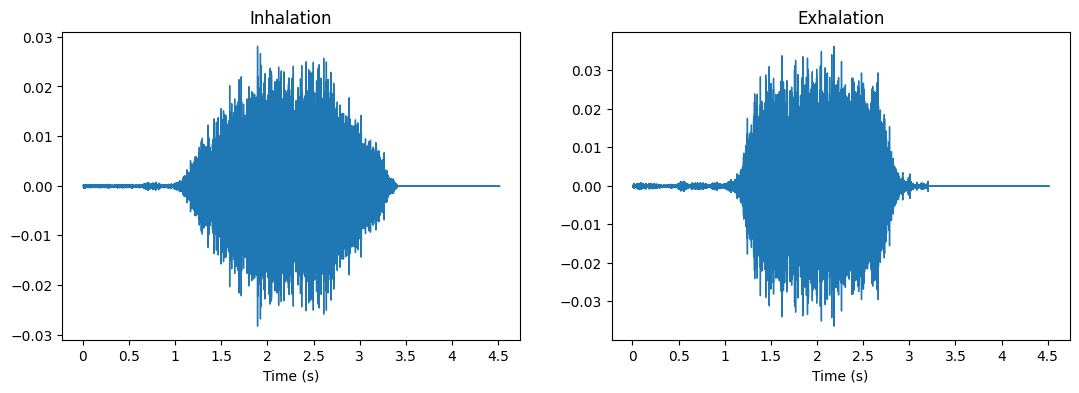

In [2]:
################# Load Inhalation and Exhalation examples #####################################
with soundfile.SoundFile(r'..\0. data\2. Data_wav\I36.wav') as audio:
    inhalation_waveform = audio.read(dtype="float32")
    sample_rate = audio.samplerate
    plt.figure(figsize=(13,4))
    plt.subplot(1, 2, 1)
    librosa.display.waveshow(inhalation_waveform, sr=sample_rate)
    plt.xlabel('Time (s)')
    plt.title('Inhalation')

with soundfile.SoundFile(r'..\0. data\2. Data_wav\E79.wav') as audio:
    exhalation_waveform = audio.read(dtype="float32")
    sample_rate = audio.samplerate
    plt.subplot(1, 2, 2)
    librosa.display.waveshow(exhalation_waveform, sr=sample_rate)
    plt.xlabel('Time (s)')
    plt.title('Exhalation')

# Feature Set 1: Spectrogram

Power spectrogram derived from Short-Time Fourier Transform (STFT), representing time-varying frequency content.

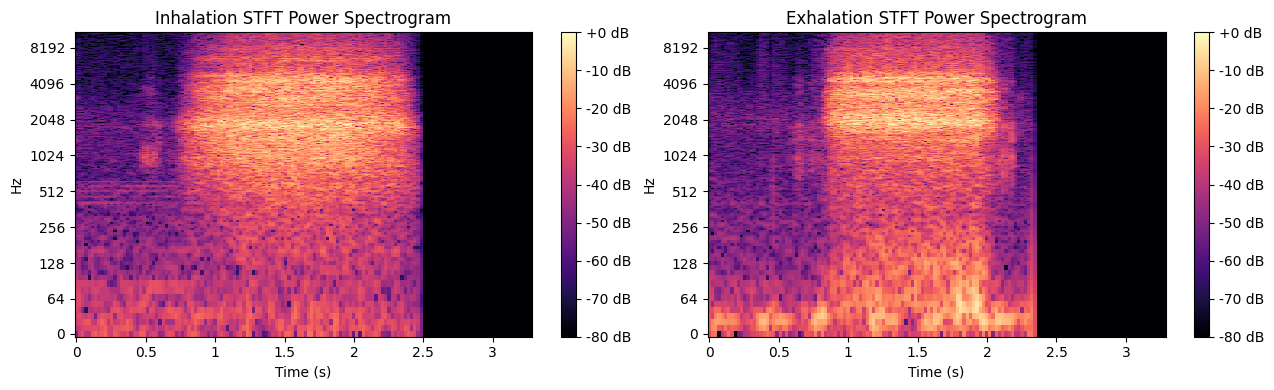

In [3]:
stft_spectrum_matrix = librosa.stft(inhalation_waveform)
plt.figure(figsize=(13,4))
plt.subplot(1, 2, 1)
librosa.display.specshow(librosa.amplitude_to_db(np.abs(stft_spectrum_matrix), ref=np.max),y_axis='log', x_axis='time')
plt.xlabel('Time (s)')
plt.title('Inhalation STFT Power Spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()

stft_spectrum_matrix = librosa.stft(exhalation_waveform)
plt.subplot(1, 2, 2)
librosa.display.specshow(librosa.amplitude_to_db(np.abs(stft_spectrum_matrix), ref=np.max),y_axis='log', x_axis='time')
plt.xlabel('Time (s)')
plt.title('Exhalation STFT Power Spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()

# Feature Set 2: Mel Spectrogram

Perceptually scaled spectrogram aligned with the human auditory system’s frequency sensitivity.

(Apply a mel-scale-based transformation, mel filterbanks (triangular window functions) to each STFT power spectrogram and sum the power in each filterbank.)

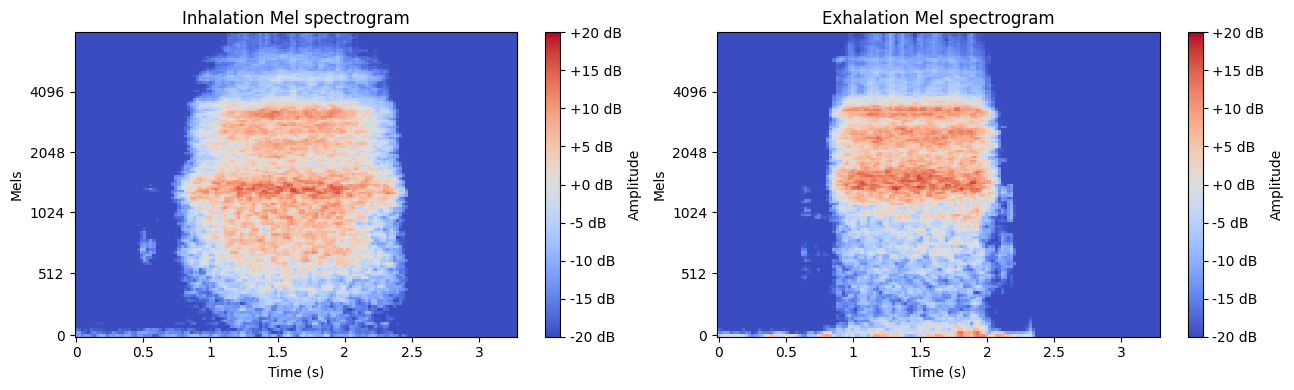

In [4]:
from matplotlib.colors import Normalize
melspectrogram = librosa.feature.melspectrogram(y=inhalation_waveform, sr=sample_rate, n_mels=128, fmax=8000)
plt.figure(figsize=(13,4))
plt.subplot(1, 2, 1)
librosa.display.specshow(librosa.power_to_db(S=melspectrogram, ref=np.mean),y_axis='mel',fmax=8000, x_axis='time', norm=Normalize(vmin=-20,vmax=20))
plt.colorbar(format='%+2.0f dB',label='Amplitude')
plt.xlabel('Time (s)')
plt.ylabel('Mels')
plt.title('Inhalation Mel spectrogram')
plt.tight_layout()

melspectrogram = librosa.feature.melspectrogram(y=exhalation_waveform, sr=sample_rate, n_mels=128, fmax=8000)
plt.subplot(1, 2, 2)
librosa.display.specshow(librosa.power_to_db(S=melspectrogram, ref=np.mean),y_axis='mel',fmax=8000, x_axis='time', norm=Normalize(vmin=-20,vmax=20))
plt.colorbar(format='%+2.0f dB',label='Amplitude')
plt.xlabel('Time (s)')
plt.ylabel('Mels')
plt.title('Exhalation Mel spectrogram')
plt.tight_layout()

# Feature Set 3: MFCC (Mel-Frequency Cepstral Coefficients)

Encodes the spectral envelope of the signal, commonly used for capturing timbral characteristics.

(Take the discrete cosine transform (DCT) of each log power in each STFT frame, giving us the MFC coefficients.)

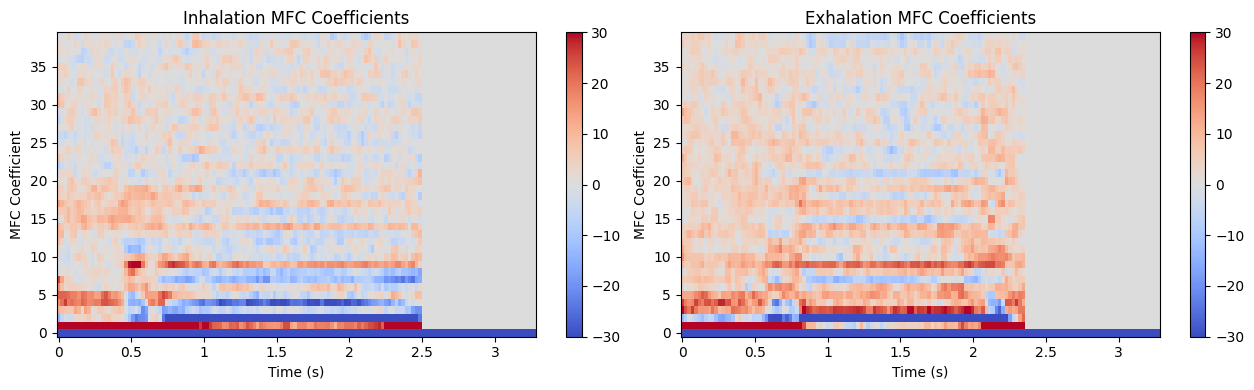

In [5]:
from matplotlib.colors import Normalize
mfc_coefficients = librosa.feature.mfcc(y=inhalation_waveform, sr=sample_rate, n_mfcc=40)
plt.figure(figsize=(13,4))
plt.subplot(1, 2, 1)
librosa.display.specshow(mfc_coefficients, x_axis='time',norm=Normalize(vmin=-30,vmax=30))
cb = plt.colorbar()
cb.set_alpha(100)
# cb.outline.set_visible(False)  # Optionally hide the colorbar outline

plt.yticks(ticks=np.arange(0, 40, 5))
plt.xlabel('Time (s)')
plt.ylabel('MFC Coefficient')
plt.title('Inhalation MFC Coefficients')
plt.tight_layout()
                                        
mfc_coefficients = librosa.feature.mfcc(y=exhalation_waveform, sr=sample_rate, n_mfcc=40)
plt.subplot(1, 2, 2)
librosa.display.specshow(mfc_coefficients, x_axis='time',norm=Normalize(vmin=-30,vmax=30))
plt.colorbar()
plt.yticks(ticks=np.arange(0, 40, 5))
plt.xlabel('Time (s)')
plt.ylabel('MFC Coefficient')
plt.title('Exhalation MFC Coefficients')
plt.tight_layout()

# Feature Set 4:Chromagram

Maps audio onto 12 pitch classes (independent of octave), capturing harmonic and tonal features.

(A chromagram is a representation of an audio signal w.r.t. time, mapping audio signal to a pitch class. )

(Most often, we map to the 12 standard pitch classes (i.e. the musical scale CDEFGAB + 5 semitones gives us 12 pitch classes).)

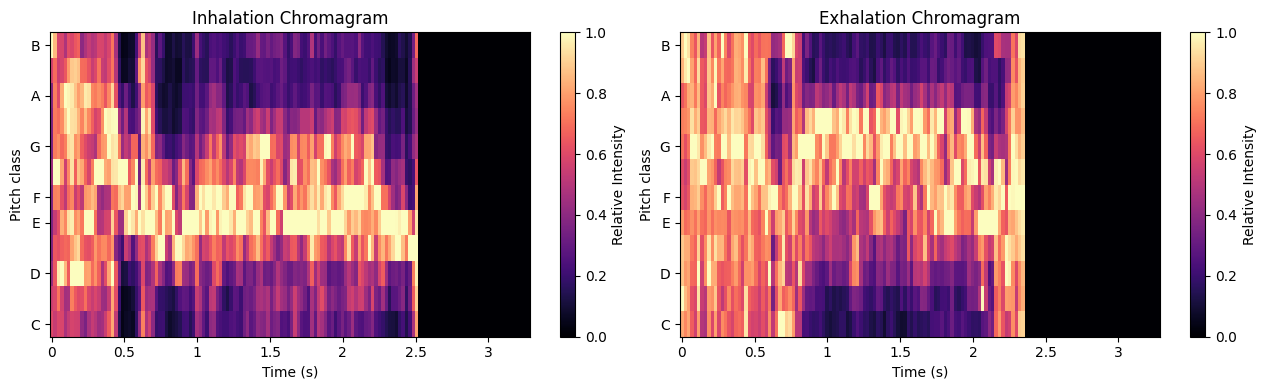

In [6]:
chromagram = librosa.feature.chroma_stft(y=inhalation_waveform, sr=sample_rate)
plt.figure(figsize=(13, 4))
plt.subplot(1,2,1)
librosa.display.specshow(chromagram, y_axis='chroma', x_axis='time')
plt.colorbar(label='Relative Intensity')
plt.xlabel('Time (s)')
plt.title('Inhalation Chromagram')
plt.tight_layout()

chromagram = librosa.feature.chroma_stft(y=exhalation_waveform, sr=sample_rate)
plt.subplot(1,2,2)
librosa.display.specshow(chromagram, y_axis='chroma', x_axis='time')
plt.colorbar(label='Relative Intensity')
plt.xlabel('Time (s)')
plt.title('Exhalation Chromagram')
plt.tight_layout()

# Feature Set 5: Combination-1
Spectrogram (mean) + Spectral Centroid + Bandwidth: A compact representation combining frequency structure with statistical measures of brightness and spread.

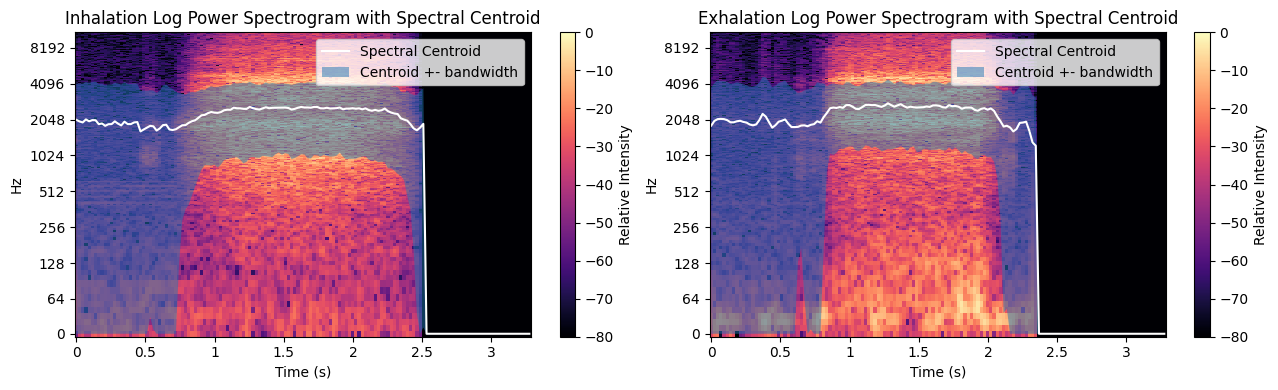

In [7]:
centroid_inhalation = librosa.feature.spectral_centroid(y=inhalation_waveform, sr=sample_rate)
S_inhalation, phase_inhalation = librosa.magphase(librosa.stft(y=inhalation_waveform))
times_inhalation = librosa.times_like(centroid_inhalation)
spec_bw_inhalation = librosa.feature.spectral_bandwidth(y=inhalation_waveform, sr=sample_rate)

plt.figure(figsize=(13, 4))
plt.subplot(1,2,1)
librosa.display.specshow(librosa.amplitude_to_db(S_inhalation, ref=np.max),
                         y_axis='log', x_axis='time')
plt.plot(times_inhalation, centroid_inhalation.T, label='Spectral Centroid', color='w')
plt.fill_between(times_inhalation, np.maximum(0, centroid_inhalation[0] - spec_bw_inhalation[0]),
                np.minimum(centroid_inhalation[0] + spec_bw_inhalation[0], sample_rate/2),
                alpha=0.5, label='Centroid +- bandwidth')

plt.legend(loc='upper right')
plt.colorbar(label='Relative Intensity')
plt.xlabel('Time (s)')
plt.title('Inhalation Log Power Spectrogram with Spectral Centroid')
plt.tight_layout()

centroid_exhalation = librosa.feature.spectral_centroid(y=exhalation_waveform, sr=sample_rate)
S_exhalation, phase_exhalation = librosa.magphase(librosa.stft(y=exhalation_waveform))
times_exhalation = librosa.times_like(centroid_exhalation)
spec_bw_exhalation = librosa.feature.spectral_bandwidth(y=exhalation_waveform, sr=sample_rate)

plt.subplot(1,2,2)
librosa.display.specshow(librosa.amplitude_to_db(S_exhalation, ref=np.max),
                         y_axis='log', x_axis='time')
plt.plot(times_exhalation, centroid_exhalation.T, label='Spectral Centroid', color='w')
plt.fill_between(times_exhalation, np.maximum(0, centroid_exhalation[0] - spec_bw_exhalation[0]),
                np.minimum(centroid_exhalation[0] + spec_bw_exhalation[0], sample_rate/2),
                alpha=0.5, label='Centroid +- bandwidth')

plt.legend(loc='upper right')
plt.colorbar(label='Relative Intensity')
plt.xlabel('Time (s)')
plt.title('Exhalation Log Power Spectrogram with Spectral Centroid')
plt.tight_layout()

# Feature Set 6: Combination-All features
An integrated feature vector comprising  Combinition 1 + Mel Spectrogram(mean) + MFCC + Chromagram(mean), offering a high-dimensional, information-rich representation.